In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
import binarization_functions as bf
import blackSheepCPTACmoduleCopy as blsh
import gseapy as gp
from gseapy.plot import barplot, heatmap, dotplot
import json
import requests
import random
import deva

In [11]:
cptac.download(dataset='ccrcc')

re = cptac.Ccrcc()
proteomics = re.get_proteomics()
clinical = re.get_clinical()

## Step 2: Determine what attributes you would like to A/B test. 
For this analysis, we will iteratively go through the various columns in the clinical dataset, to determine if any of them have trends within them for protein enrichment.

In [12]:
# Data cleaning. We want to get rid of non-clear cell carcinoma, 
# as it skews our analysis, as it is not what we are studying
non_clear_cell_filter = clinical['histologic_type'] == 'non-Clear Cell renal cell carcinoma'
clinical = clinical[~non_clear_cell_filter]

# We also need to get rid of those samples in the datasets we plan to use. In this case, Proteomics.
rows_to_drop = ['S011', 'S097', 'S104', 'S107', 'S115', 'S119', 'S123']

proteomics.drop(rows_to_drop)

print("Rows Dropped:")
print(rows_to_drop)

Rows Dropped:
['S011', 'S097', 'S104', 'S107', 'S115', 'S119', 'S123']


From previous exploratory analysis (In "Outlier_Analysis_Renal.ipynb"), many columns were found to have significant gene enrichments for one of their binary attributes.  Here we will explore several of those signficant features, to dive deeper into some of the more interesting trends.

In [13]:
columns_to_explore = ['tumor_size_in_cm', 
                      'tumor_focality', 
                      'history_of_cancer', 
                      'vital_status_at_12months_follow_up', 
                      'tumor_status_at_12months_follow_up', 
                      'tumor_necrosis', 
                      'margin_status']

#Create a subsetted copy of the original Clinical DataFrame
annotations = pd.DataFrame(clinical[columns_to_explore].copy())

#Then we will make any non-binary columns binary
col = 'tumor_size_in_cm'
col_mean = annotations[col].mean()
annotations[col]= bf.binarizeCutOff(annotations, col, col_mean, 
                                    "Above_Mean("+str(round(col_mean, 2))+")", 
                                    "Below_Mean("+str(round(col_mean, 2))+")")

col2 = 'tumor_status_at_12months_follow_up'
annotations[col2] = annotations[col2].replace('Unknown', np.nan)

## Step 3: Perform Outlier Analysis
We will first create outlier tables for significantly up and down regulated gene enrichments

In [14]:
outliers_up = blsh.make_outliers_table(proteomics, iqrs=1.5, 
                                       up_or_down='up', 
                                       aggregate=False, 
                                       frac_table=False)

outliers_down = blsh.make_outliers_table(proteomics, iqrs=1.5, 
                                         up_or_down='down', 
                                         aggregate=False, 
                                         frac_table=False)

In [15]:
length = int(len(outliers_up.index) / 2)
only_outliers_up = outliers_up[:length]
outliers_up_dict = {}
for i in range(length):
    key = proteomics.index[i]
    my_filter = only_outliers_up.iloc[i] == 1.0
    value = list(only_outliers_up.iloc[i][my_filter].index)
    outliers_up_dict[key] = value

length = int(len(outliers_down.index) / 2)
only_outliers_down = outliers_down[:length]
outliers_down_dict = {}
for i in range(length):
    key = proteomics.index[i]
    my_filter = only_outliers_down.iloc[i] == 1.0
    value = list(only_outliers_down.iloc[i][my_filter].index)
    outliers_down_dict[key] = value

## Step 4: Wrap your A/B test into the outliers analysis, and create a table
Note: compare_groups_outliers will break if there are duplicate gene names. Be sure to use the 
renameDuplicateColumns function if there are indexing errors

In [6]:
bf.renameDuplicateColumns(outliers_up)
bf.renameDuplicateColumns(outliers_down)

In [8]:
results_up = blsh.compare_groups_outliers(outliers_up, 
                                          annotations)

results_down = blsh.compare_groups_outliers(outliers_down, 
                                            annotations)

results_up = results_up.dropna(axis=0, how='all')
results_down = results_down.dropna(axis=0, how='all')

## Step 5: Visualize these enrichments

First, we will determine which clinical attributes have significant enrichments, and save them to a list for both up-regulated outliers, and down-regulated outliers.

In [17]:
#Drop Columns with less than 4 significant up-regulated enrichments
sig_cols_up = []
for col in results_up.columns:
    sig_col = bf.significantEnrichments(results_up, col)
    if sig_col is not None and len(sig_col) >= 4:
        sig_cols_up.append(sig_col)
    else:
        results_up = results_up.drop(col, axis=1)

#Drop Columns with less than 4 significant down-regulated enrichments
sig_cols_down = []
for col in results_down.columns:
    sig_col = bf.significantEnrichments(results_down, col)
    if sig_col is not None and len(sig_col) >= 4:
        sig_cols_down.append(sig_col)
    else:
        results_down = results_down.drop(col, axis=1)

In [8]:
#Here we will link clinical attributes with significantly up-regulated genes
sig_genes_up = {}
for i, col in enumerate(sig_cols_up):
    list_of_genes = list(col.index)
    #Get rid of duplicate parentheses if they exist
    for j, gene in enumerate(list_of_genes):
        if "(" in gene:
            list_of_genes[j] = gene[:-3]
    list_of_genes = list(set(list_of_genes))
    sig_genes_up[sig_cols_up[i].columns[0][:-9]] = list_of_genes   

#And then down-regulated genes
sig_genes_down = {}
for i, col in enumerate(sig_cols_down):
    list_of_genes = list(col.index)
    for j, gene in enumerate(list_of_genes):
        if "(" in gene:
            list_of_genes[j] = gene[:-3]
    list_of_genes = list(set(list_of_genes))
    sig_genes_down[sig_cols_down[i].columns[0][:-9]] = list_of_genes   

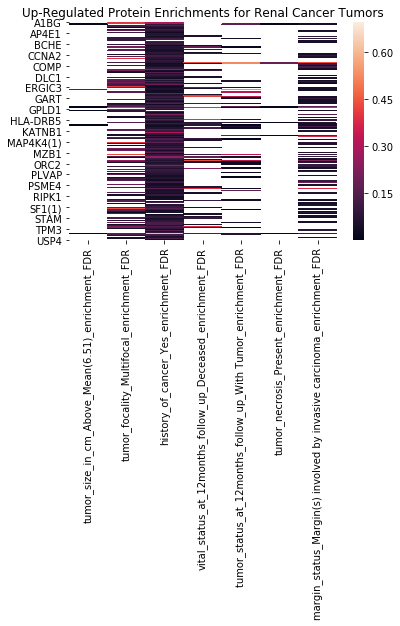

In [22]:
ax1 = plt.axes()
sns.heatmap(results_up, ax = ax1)
ax1.set_title('Up-Regulated Protein Enrichments for Renal Cancer Tumors')
plt.show()

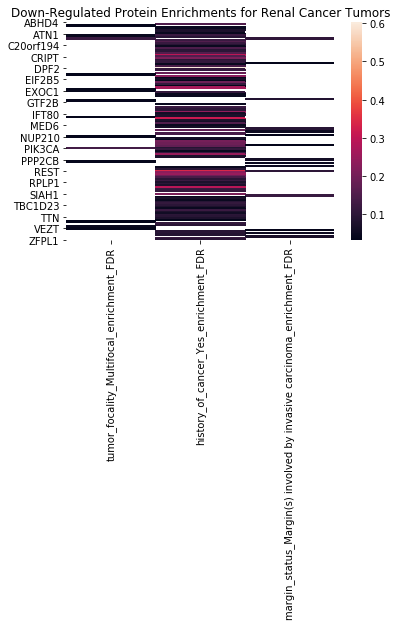

In [23]:
ax2 = plt.axes()
sns.heatmap(results_down, ax = ax2)
ax2.set_title('Down-Regulated Protein Enrichments for Renal Cancer Tumors')
plt.show()

## Step 6: Perform Gene Set Enrichment Analysis

In [25]:
gsea_up = {}
for col in sig_cols_up:
    col_name = col.columns[0]
    col_name = "_".join(col_name.split(" "))
    print(col_name[:-9])
    gene_name_list = list(col.index)
    #This will get rid of parentheses that would interfere with GSEA
    for i, item in enumerate(gene_name_list):
        if "(" in item:
            gene_name_list[i] = item[:-3]
    gene_name_list = list(set(gene_name_list))
    print('Gene List:', gene_name_list)
    enrichment = gp.enrichr(gene_list = gene_name_list, 
                            description=col_name, 
                            gene_sets='KEGG_2019_Human', 
                            outdir='test/renal')
    gsea_up[col_name] = enrichment
    barplot(enrichment.res2d, title=col_name, ofname=col_name)

tumor_size_in_cm_Above_Mean(6.51)
Gene List: ['GOLPH3L', 'IGF2BP3', 'GSDME', 'ACBD3', 'TXNRD1']


2019-08-30 10:40:02,767 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
08/30/2019 10:40:02:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


tumor_focality_Multifocal
Gene List: ['NEK9', 'AGL', 'MCF2L', 'TLN2', 'KRT8', 'CTPS2', 'DCAF7', 'PPIA', 'RCBTB2', 'PLEC', 'SDK1', 'HDAC4', 'SNTB1', 'ZC2HC1A', 'UPF3A', 'ATG5']


2019-08-30 10:40:05,547 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
08/30/2019 10:40:05:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


history_of_cancer_Yes
Gene List: ['STN1', 'PSME4', 'SRPK1', 'GNAS', 'AP5B1', 'MCRS1', 'ATP7A', 'YOD1', 'IL6ST', 'TTLL4', 'LARP6', 'CLNS1A', 'CAAP1', 'KCMF1', 'RAD23A', 'STARD8', 'DNAJC16', 'HBA2', 'RNF135', 'HBE1', 'CNOT8', 'GID8', 'C4B', 'COMMD8', 'F13B', 'SPTA1', 'USP42', 'DAZAP2', 'NAP1L1', 'PRDX2', 'FCN3', 'WRAP53', 'DHX40', 'EPB41', 'SAV1', 'CEP128', 'DOHH', 'GYPC', 'PUS7L', 'HRG', 'CYTH2', 'FGA', 'BCCIP', 'RBM4', 'RNF123', 'ERF', 'PLEKHG4B', 'RPL22', 'FLII', 'RNPS1', 'DENND4B', 'SLC4A1', 'NBEAL2', 'CACHD1', 'GEMIN2', 'PSMC6', 'FGB', 'AP4E1', 'UBQLN1', 'DOLK', 'MTRR', 'ZBTB33', 'INTU', 'CA3', 'CA1', 'SPRY1', 'ADD2', 'DLC1', 'BPGM', 'C9orf40', 'ARG1', 'RFESD', 'RMND5A', 'HBB', 'TPST2', 'POMGNT1', 'PON3', 'PTBP1', 'FBXO7', 'STOM', 'CNDP1', 'LSM12', 'SLC9A6', 'HMBS', 'FGG', 'MAPK14']
vital_status_at_12months_follow_up_Deceased
Gene List: ['NUDC', 'CALCOCO1', 'FLNC', 'CSE1L', 'NPC1', 'RBCK1', 'DLG5', 'BMP1', 'TFPI2', 'SFN', 'EIF3D', 'CMAS', 'SPICE1']


2019-08-30 10:40:12,893 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
08/30/2019 10:40:12:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


tumor_status_at_12months_follow_up_With_Tumor
Gene List: ['TARS', 'NUDC', 'C12orf29', 'POP1', 'TNPO3', 'PKP3', 'GALNT2', 'GLS', 'IGF2BP3', 'MAGED1', 'PDIA6', 'PYCR2', 'GORASP2', 'ASPH', 'RRBP1', 'IRS2', 'CALR', 'ORC5', 'SLC38A10']


2019-08-30 10:40:15,720 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
08/30/2019 10:40:15:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


tumor_necrosis_Present
Gene List: ['LARP1', 'GOLPH3L', 'HSP90AB1', 'ACBD3', 'TXNRD1']


2019-08-30 10:40:18,501 Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05
08/30/2019 10:40:18:WARNING:Warning: No enrich terms using library KEGG_2019_Human when cutoff = 0.05


margin_status_Margin(s)_involved_by_invasive_carcinoma
Gene List: ['GBF1', 'GCN1', 'NUDC', 'ALDH1L2', 'UGGT1', 'PDIA6', 'RRBP1', 'SIL1', 'IGBP1', 'EIF3E', 'SEC11C', 'ERLEC1', 'SRPRA', 'TARS', 'SPCS3', 'MAGT1', 'CRELD2', 'CD38', 'IRS2', 'COPA', 'PIGT', 'SRP68', 'CC2D1A', 'ACBD3', 'G6PD', 'CALR', 'PIGS', 'GSPT1', 'ATP2A2', 'GLMN', 'GLRX3', 'RPS6KA3', 'SDF2L1', 'DNALI1', 'FAM192A', 'EIF2B5', 'SRSF9', 'NSF', 'SMAD3', 'POFUT1', 'DHCR24', 'ECE1', 'NPC1', 'FXYD1', 'NMT1', 'IGF2BP3', 'B3GAT3', 'HDLBP', 'TANC2', 'HYOU1']


Determine significant overlap for significantly up-regulated genes, first for patients with a history of cancer, adn then for patients with invasive carcinoma.

In [11]:
#Significant overlap for patients with a history of cancer
cancer_history_yes = gsea_up['history_of_cancer_Yes_P_values'].res2d
sig_filter = cancer_history_yes['Adjusted P-value'] < 0.05
cancer_history_sig = cancer_history_yes[sig_filter]
cancer_history_sig

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Human,Complement and coagulation cascades,5/79,0.000023,0.007065,0,0,14.718870,157.236539,C4B;FGB;FGA;FGG;F13B
1,KEGG_2019_Human,Platelet activation,5/124,0.000197,0.030336,0,0,9.377344,80.010929,FGB;FGA;FGG;GNAS;MAPK14


In [12]:
genes = cancer_history_sig['Genes']
terms = cancer_history_sig['Term']
cancer_history_dict = {}
for i, gene in enumerate(genes):
    cancer_history_dict[terms[i]] = gene.split(';')
cancer_history_dict

{'Complement and coagulation cascades': ['C4B', 'FGB', 'FGA', 'FGG', 'F13B'],
 'Platelet activation': ['FGB', 'FGA', 'FGG', 'GNAS', 'MAPK14']}

In [13]:
cancer_history_yes_requests = {}
cancer_history_requests_parsed = {}
for term, gene_list in cancer_history_dict.items():
    cancer_history_yes_requests[term] = bf.dgidb_get_request(gene_list)
    cancer_history_requests_parsed[term] = bf.dgidb_json_parse(cancer_history_yes_requests[term], genes=True)

print(json.dumps(cancer_history_requests_parsed, indent=4))

{
    "Complement and coagulation cascades": {
        "C4B": {
            "GLOBULIN, IMMUNE": [
                "binder"
            ]
        },
        "FGB": {
            "Sucralfate": [
                "antagonist"
            ],
            "FIBRINOLYSIN, HUMAN": [
                "inhibitor"
            ],
            "ALFIMEPRASE": [],
            "EPTIFIBATIDE": [],
            "TIROFIBAN": [],
            "ABCIXIMAB": []
        },
        "FGA": {
            "Sucralfate": [
                "antagonist"
            ],
            "FIBRINOLYSIN, HUMAN": [
                "inhibitor"
            ],
            "EPTIFIBATIDE": [],
            "ANISTREPLASE": [],
            "ANCROD": [],
            "ABCIXIMAB": [],
            "RETEPLASE": [],
            "ALTEPLASE": [],
            "ALFIMEPRASE": [],
            "TENECTEPLASE": [],
            "TIROFIBAN": []
        },
        "FGG": {
            "Sucralfate": [
                "antagonist"
            ],
            "FI

In [14]:
#Determine significant overlap for patients with invasive carcinoma
invasive_cancer = gsea_up['margin_status_Margin(s)_involved_by_invasive_carcinoma_P_values'].res2d
sig_filter = invasive_cancer['Adjusted P-value'] < 0.05
invasive_sig = invasive_cancer[sig_filter]
invasive_sig

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2019_Human,Protein processing in endoplasmic reticulum,7/165,1.696952e-07,0.000052,0,0,16.969697,264.545051,ERLEC1;RRBP1;HYOU1;CALR;PDIA6;SIL1;UGGT1
1,KEGG_2019_Human,Protein export,4/23,2.954349e-07,0.000045,0,0,69.565217,1045.900339,SPCS3;SRPRA;SRP68;SEC11C


In [15]:
genes = invasive_sig['Genes']
terms = invasive_sig['Term']
invasive_dict = {}
for i, gene in enumerate(genes):
    invasive_dict[terms[i]] = gene.split(';')

In [16]:
invasive_cancer_requests = {}
invasive_requests_parsed = {}
for term, gene_list in invasive_dict.items():
    invasive_cancer_requests[term] = bf.dgidb_get_request(gene_list)#, anti_neoplastic=True)
    invasive_requests_parsed[term] = bf.dgidb_json_parse(invasive_cancer_requests[term], genes=True)

print("Parsed Requests:\n")
print(json.dumps(invasive_requests_parsed, indent=4))

Parsed Requests:

{
    "Protein processing in endoplasmic reticulum": {
        "CALR": {
            "TRETINOIN": [],
            "GENTAMICIN": [],
            "TENECTEPLASE": [],
            "ETRETINATE": [],
            "MELATONIN": [],
            "OLTIPRAZ": []
        }
    },
    "Protein export": null
}


## Step 7: Personalized Medicine

In [17]:
# To perform a request specifically for inhibitors, you may opt to use a loop
# While this option is slower than the map, it is more specific, and may be worth
# waiting a few more seconds to reduce manual sifting through interaction types
inhibitors = {}
for attribute, genes in sig_genes_up.items():
    inhibitors[attribute] = bf.dgidb_get_request(genes, interaction_types=['inhibitor'])

In [18]:
print('UP-REGULATED INHIBITOR REQUEST:\n')
inhibitors_parsed = {}
for attribute, request in inhibitors.items():
    inhibitors_parsed[attribute] = bf.dgidb_json_parse(request, genes=True)
print(json.dumps(inhibitors_parsed, indent=4))

UP-REGULATED INHIBITOR REQUEST:

{
    "tumor_size_in_cm_Above_Mean(6.51)": {
        "TXNRD1": {
            "ARSENIC TRIOXIDE": [
                "inhibitor"
            ]
        }
    },
    "tumor_focality_Multifocal": {
        "PPIA": {
            "CYCLOSPORINE": [
                "modulator",
                "inhibitor"
            ]
        },
        "HDAC4": {
            "PANOBINOSTAT": [
                "inhibitor"
            ],
            "CUDC-101": [
                "inhibitor"
            ],
            "CHEMBL1851943": [
                "inhibitor"
            ],
            "ROMIDEPSIN": [
                "inhibitor"
            ],
            "SCRIPTAID": [
                "inhibitor"
            ],
            "ABEXINOSTAT": [
                "inhibitor"
            ],
            "CHEMBL3110004": [
                "inhibitor"
            ],
            "VORINOSTAT": [
                "inhibitor"
            ],
            "PANOBINOSTAT LACTATE": [
             

}


In [19]:
patient_drugs_genes_up = bf.compare_enrichments_with_drugs(outliers_up_dict, clinical)

{
    "S001": {
        "current_medications": [
            "rivaroxaban",
            "tylenol",
            "Aspirin",
            "glycolax",
            "colace",
            "zocor"
        ],
        "ASPIRIN": {
            "RPS6KA3": []
        }
    },
    "S002": {
        "current_medications": [
            "Rivaroxaban",
            "Esomeprazole ",
            "Tramadol"
        ]
    },
    "Gene/Drug Interactions": "No connection between current drugs and significantly enriched genes",
    "S003": {
        "current_medications": [
            "Multi Vitamin",
            "Levothyroxine Sodium",
            "Ibandronate Sodium",
            "Aspirin",
            "Calcium Carb-Cholecalciferol",
            "Naproxen Sodium",
            "Diphenhydramine-APAP",
            "Escitalopram Oxalate"
        ],
        "ASPIRIN": {
            "IRS2": []
        }
    },
    "S004": {
        "current_medications": [
            "Levothyroxine Sodium",
            "Cyprohept

}


In [20]:
patients_to_check_up = []
for i in range(3):
    index = random.randrange(0, len(only_outliers_up))
    patients_to_check_up.append(clinical.index[index])

In [21]:
personalized_up = {}
for patient in patients_to_check_up:
    patients_up_dict = bf.dgidb_get_request(outliers_up_dict[patient], 
                                            interaction_types = ['inhibitor'])
    parsed = bf.dgidb_json_parse(patients_up_dict, genes=True)
    personalized_up[patient] = parsed
print(json.dumps(personalized_up, indent = 4))

KeyError: 'S081'